(For printing purpose)

Perform Deep Feature Synthesis to discover potential new features for the design of Star Schemas.

In [1]:
import pandas as pd
import featuretools as ft
import woodwork

# Filter unimportant warning generated by featuretools
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Display utilities
from IPython.display import display_svg

# Prepare datasets
You are provided with an e-commerce dataset comprising several entities:

1. `Customers`: CustomerID, Name, Email, SignUpDate
2. `Products`: ProductID, Name, Category, Price
3. `Orders`: OrderID, CustomerID, OrderDate, ShipDate
4. `OrderDetails`: OrderID, ProductID, Quantity, Discount

**Business Rules:**

1. One `customer` can place <u>one or many</u> `orders`; One `order` is placed by <u>one and only one</u> `customer`.
2. One `order` contains <u>one or many</u> `products`; One `product` belongs to <u>zero or many</u> `orders`.

| ![image.png](imgs/entity-relationship.png) |
|:-:|
| *Entity relationship diagram based on the given business rules* |

*Notes:* `OrderDetail` acts as the bridge table between `Order` to `Product` tables to create a <u>many-to-many</u> relationship.

## Generate mock-up datasets

In [3]:
# Define sample data for Customers
customers_data = {
    "CustomerID": [101, 102, 103, 104, 105],
    "Name": ["John Doe", "Jane Smith", "Mike Jordan", "Anna Frank", "Sarah Connor"],
    "Email": ["john.doe@example.com", "jane.smith@example.com", "mike.jordan@example.com", "anna.frank@example.com", "sarah.connor@example.com"],
    "SignUpDate": ["2023-01-10", "2023-01-15", "2023-01-20", "2023-01-25", "2023-01-30"]
}

# Define sample data for Products
products_data = {
    "ProductID": [201, 202, 203, 204, 205],
    "Name": ["Laptop", "Tablet", "Smartphone", "Earrings", "T-Shirt"],
    "Category": ["Electronics", "Electronics", "Electronics", "Accessories", "Clothing"],
    "Price": [1000, 500, 800, 100, 50]
}

# Define sample data for Orders
orders_data = {
    "OrderID": [301, 302, 303, 304, 305],
    "CustomerID": [101, 102, 103, 104, 105],
    "OrderDate": ["2023-02-01", "2023-02-05", "2023-02-10", "2023-02-15", "2023-02-20"],
    "ShipDate": ["2023-02-03", "2023-02-07", "2023-02-12", "2023-02-19", "2023-02-25"]
}

# Define sample data for OrderDetails
order_details_data = {
    "OrderID": [301, 302, 303, 304, 304, 305, 305, 305],
    "ProductID": [201, 202, 203, 204, 205, 205, 204, 201],
    "Quantity": [1, 2, 1, 1, 3, 1, 2, 1],
    "Discount": [0, 0.1, 0, 0, 0.2, 0, 0, 0.3]
}

# Create DataFrames
customers_df = pd.DataFrame(customers_data)
products_df = pd.DataFrame(products_data)
orders_df = pd.DataFrame(orders_data)
order_details_df = pd.DataFrame(order_details_data)

# Adding a surrogate key to order_details table (to be used as an index in the entity)
order_details_df["OrderDetailID"] = order_details_df["OrderID"].astype(str) + "_" + order_details_df["ProductID"].astype(str)

In [4]:
customers_df

,CustomerID,Name,Email,SignUpDate
0,101,John Doe,john.doe@example.com,2023-01-10
1,102,Jane Smith,jane.smith@example.com,2023-01-15
2,103,Mike Jordan,mike.jordan@example.com,2023-01-20
3,104,Anna Frank,anna.frank@example.com,2023-01-25
4,105,Sarah Connor,sarah.connor@example.com,2023-01-30


In [5]:
products_df

,ProductID,Name,Category,Price
0,201,Laptop,Electronics,1000
1,202,Tablet,Electronics,500
2,203,Smartphone,Electronics,800
3,204,Earrings,Accessories,100
4,205,T-Shirt,Clothing,50


In [6]:
orders_df

,OrderID,CustomerID,OrderDate,ShipDate
0,301,101,2023-02-01,2023-02-03
1,302,102,2023-02-05,2023-02-07
2,303,103,2023-02-10,2023-02-12
3,304,104,2023-02-15,2023-02-19
4,305,105,2023-02-20,2023-02-25


In [7]:
order_details_df

,OrderID,ProductID,Quantity,Discount,OrderDetailID
0,301,201,1,0.0,301_201
1,302,202,2,0.1,302_202
2,303,203,1,0.0,303_203
3,304,204,1,0.0,304_204
4,304,205,3,0.2,304_205
5,305,205,1,0.0,305_205
6,305,204,2,0.0,305_204
7,305,201,1,0.3,305_201


# Define Entities & EntitySet

In [8]:
es = ft.EntitySet(id="order_data")

es.add_dataframe(
    dataframe_name="Customer",
    dataframe=customers_df,
    index="CustomerID",
    time_index="SignUpDate",
    logical_types={
        "CustomerID": woodwork.logical_types.Integer,
        "Name": woodwork.logical_types.PersonFullName,
        "Email": woodwork.logical_types.EmailAddress,
        "SignUpDate": woodwork.logical_types.Datetime,
    },
)

es.add_dataframe(
    dataframe_name="Product",
    dataframe=products_df,
    index="ProductID",
    logical_types={
        "ProductID": woodwork.logical_types.Integer,
        "Name": woodwork.logical_types.NaturalLanguage,
        "Category": woodwork.logical_types.Categorical,
        "Price": woodwork.logical_types.Double,
    },
)

es.add_dataframe(
    dataframe_name="Order",
    dataframe=orders_df,
    index="OrderID",
    time_index="OrderDate",
    logical_types={
        "OrderID": woodwork.logical_types.Integer,
        "CustomerID": woodwork.logical_types.Integer,
        "OrderDate": woodwork.logical_types.Datetime,
        "ShipDate": woodwork.logical_types.Datetime,
    },
)

es.add_dataframe(
    dataframe_name="OrderDetail",
    dataframe=order_details_df,
    index="OrderDetailID",
    logical_types={
        "OrderDetailID": woodwork.logical_types.Categorical,
        "OrderID": woodwork.logical_types.Integer,
        "ProductID": woodwork.logical_types.Integer,
        "Quantity": woodwork.logical_types.Integer,
        "Discount": woodwork.logical_types.Double,
    },
)


Entityset: order_data
  DataFrames:
    Customer [Rows: 5, Columns: 4]
    Product [Rows: 5, Columns: 4]
    Order [Rows: 5, Columns: 4]
    OrderDetail [Rows: 8, Columns: 5]
  Relationships:
    No relationships

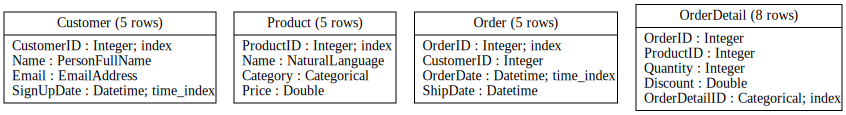

In [9]:
display_svg(es.plot()) 

# Establish relationship between entities

Recall the business rules and ERD from [Section 1](#Prepare-datasets).

In [10]:
es.add_relationships([
    ft.Relationship(es, "Customer", "CustomerID", "Order", "CustomerID"),
    ft.Relationship(es, "Order", "OrderID", "OrderDetail", "OrderID"),
    ft.Relationship(es, "Product", "ProductID", "OrderDetail", "ProductID"),
])

Entityset: order_data
  DataFrames:
    Customer [Rows: 5, Columns: 4]
    Product [Rows: 5, Columns: 4]
    Order [Rows: 5, Columns: 4]
    OrderDetail [Rows: 8, Columns: 5]
  Relationships:
    Order.CustomerID -> Customer.CustomerID
    OrderDetail.OrderID -> Order.OrderID
    OrderDetail.ProductID -> Product.ProductID

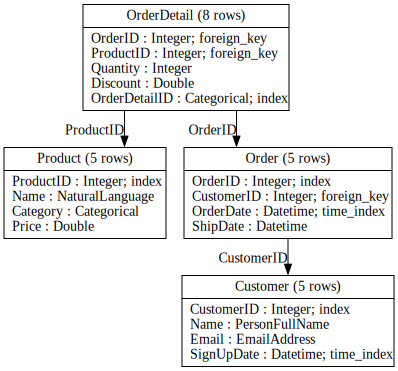

In [11]:
display_svg(es.plot())

# Perform Deep Feature Synthesis to discover new features

Exploring [possible primitives](https://featuretools.alteryx.com/en/stable/api_reference.html#feature-primitives) to apply:

- agg_primitives (default): ["sum", "std", "max", "skew", "min", "mean", "count", "percent_true", "num_unique", "mode"]
- trans_primitives (default): ["day", "year", "month", "weekday", "haversine", "num_words", "num_characters"]

In [12]:
primitive_list = ft.list_primitives()
primitive_list[primitive_list["type"] == "aggregation"].reset_index(drop=True)[["name", "type", "description"]]

,name,type,description
0,percent_true,aggregation,Determines the percent of `True` values.
1,time_since_last_true,aggregation,Calculates the time since the last `True` value.
2,count_outside_range,aggregation,Determines the number of values that fall outs...
3,first,aggregation,Determines the first value in a list.
4,n_unique_weeks,aggregation,Determines the number of unique weeks.
...,...,...,...
60,mean,aggregation,Computes the average for a list of values.
61,min,aggregation,"Calculates the smallest value, ignoring `NaN` ..."
62,time_since_last_false,aggregation,Calculates the time since the last `False` value.
63,max,aggregation,"Calculates the highest value, ignoring `NaN` v..."


In [13]:
primitive_list[primitive_list["type"] == "transform"].reset_index(drop=True)[["name", "type", "description"]]

,name,type,description
0,scalar_subtract_numeric_feature,transform,Subtracts each value in the list from a given ...
1,days_in_month,transform,Determines the number of days in the month of ...
2,median_word_length,transform,Determines the median word length.
3,less_than_equal_to_scalar,transform,Determines if values are less than or equal to...
4,cum_count,transform,Calculates the cumulative count.
...,...,...,...
133,second,transform,Determines the seconds value of a datetime.
134,num_characters,transform,Calculates the number of characters in a given...
135,divide_by_feature,transform,Divides a scalar by each value in the list.
136,diff,transform,Computes the difference between the value in a...


## Exploring `Customer` table

Drilling down on `Customer` table to find out potential features.

In [14]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="Customer",
    max_depth=2,
    agg_primitives=["sum", "mean", "count"],
    trans_primitives=None, # default
)

#### Result

Performing DFS on `Customer` table doesn't seem to produce any meaningful feature that can be used for the design of data warehouse's star schema...

## Exploring `Product` table

Drilling down on `Product` table to find out potential features.

In [15]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="Product",
    max_depth=3,
    agg_primitives=["sum", "mean", "count"],
    trans_primitives=None, # default
)

#### Result

Same for `Product` table, DFS doesn't discover any useful feature for data warehouse modeling.

## Exploring `Order` table

Drilling down on `Order` table to find out potential features.

Defining a [Custom TransformPrimitive](https://featuretools.alteryx.com/en/stable/getting_started/primitives.html#Defining-Custom-Primitives):

| Custom Transform Primitive | Description |
|:-:|:- |
| **SubtractDatetime** | `Order` table contains `ShipDate` and `OrderDate`, a plausible feature would be `DaysToShip`, which is the number of days takes to ship the order once it has been placed. Since Featuretools doesn't provide a transform primitive for subtracting datetime, we'd have to implement a custom transform primitive for it. |
| **MultiplyThreeNumeric** | Featuretools only provides a transform primitive known as *MultiplyNumeric* that applies multiplication to 2 list of numbers. In our case, we might need a primitive for multiplication of 3 numbers, i.e., `OrderDetail.Discount * Product.Price * Quantity` to obtain the total discount applied to an specific product. |

In [16]:
class SubtractDatetime(ft.primitives.TransformPrimitive):
    name = "subtract_datetime"
    input_types = [
        woodwork.column_schema.ColumnSchema(logical_type=woodwork.logical_types.Datetime), 
        woodwork.column_schema.ColumnSchema(logical_type=woodwork.logical_types.Datetime)
    ]
    return_type = woodwork.column_schema.ColumnSchema(semantic_tags={"numeric"})

    def get_function(self):
        def subtract_datetime(datetime1, datetime2):
            delta = (datetime1 - datetime2).dt.days
            return delta
        return subtract_datetime

class MultiplyThreeNumeric(ft.primitives.TransformPrimitive):
    name = "multiply_three_numeric"
    input_types = [
        woodwork.column_schema.ColumnSchema(semantic_tags={"numeric"}), 
        woodwork.column_schema.ColumnSchema(semantic_tags={"numeric"}), 
        woodwork.column_schema.ColumnSchema(semantic_tags={"numeric"})
    ]
    return_type = woodwork.column_schema.ColumnSchema(semantic_tags={"numeric"})
    commutative = True
    
    def __init__(self, commutative=True):
        self.commutative = commutative
    
    def get_function(self):
        def multiply_three_numeric(numeric1, numeric2, numeric3):
            return numeric1 * numeric2 * numeric3
        return multiply_three_numeric

    def generate_name(self, base_feature_names):
        return "%s * %s * %s" % (base_feature_names[0], base_feature_names[1], base_feature_names[2])

def get_feature_by_name(feature_defs, feature_name):
    """
    Helper method to obtain feature object by its name
    """
    for feat in feature_defs:
        if feat.get_name() == feature_name:
            return feat
    return None    

In [17]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="Order",
    max_depth=3,
    agg_primitives=["sum", "count"],
    trans_primitives=["multiply_numeric", SubtractDatetime, MultiplyThreeNumeric]
)

2023-11-16 03:13:51,287 featuretools - WARNING    Attempting to add feature <Feature: Customer.COUNT(Order) * SUM(OrderDetail.Discount)> which is already present. This is likely a bug.
2023-11-16 03:13:51,288 featuretools - WARNING    Attempting to add feature <Feature: Customer.COUNT(Order) * SUM(OrderDetail.Quantity)> which is already present. This is likely a bug.
2023-11-16 03:13:51,288 featuretools - WARNING    Attempting to add feature <Feature: Customer.COUNT(OrderDetail) * SUM(OrderDetail.Discount)> which is already present. This is likely a bug.
2023-11-16 03:13:51,289 featuretools - WARNING    Attempting to add feature <Feature: Customer.COUNT(OrderDetail) * SUM(OrderDetail.Quantity)> which is already present. This is likely a bug.
2023-11-16 03:13:51,290 featuretools - WARNING    Attempting to add feature <Feature: Customer.SUM(OrderDetail.Discount) * SUM(OrderDetail.Quantity)> which is already present. This is likely a bug.
2023-11-16 03:13:51,290 featuretools - WARNING    

#### Result

Perform DFS on `Order` table yields the following features that might be useful for data warehouse:

- `SUM(OrderDetail.Quantity)`: total quantity of order items for each order
- `COUNT(OrderDetail)`: total number of unique items in each order
- `SUBTRACT_DATETIME(ShipDate, OrderDate)`: number of days take to ship a product for each order
- `SUM(OrderDetail.Product.Price * Quantity)`: the amount to pay before discount for each order
- `SUM(OrderDetail.Discount * Product.Price * Quantity)`: the discount amount for each order

In [18]:
# Collect the useful features generated
order_results = {
    "OrderTotalQuantity": {
        "feature_name": "SUM(OrderDetail.Quantity)",
        "feature_obj": get_feature_by_name(feature_defs=feature_defs, feature_name="SUM(OrderDetail.Quantity)")
    },
    "OrderTotalUniqueItems": {
        "feature_name": "COUNT(OrderDetail)",
        "feature_obj": get_feature_by_name(feature_defs=feature_defs, feature_name="COUNT(OrderDetail)")
    },
    "DaysToShip": {
        "feature_name": "SUBTRACT_DATETIME(ShipDate, OrderDate)",
        "feature_obj": get_feature_by_name(feature_defs=feature_defs, feature_name="SUBTRACT_DATETIME(ShipDate, OrderDate)")
    },
    "OrderSubtotal": {
        "feature_name": "SUM(OrderDetail.Product.Price * Quantity)",
        "feature_obj": get_feature_by_name(feature_defs=feature_defs, feature_name="SUM(OrderDetail.Product.Price * Quantity)")
    },
    "OrderDiscountAmount": {
        "feature_name": "SUM(OrderDetail.Discount * Product.Price * Quantity)",
        "feature_obj": get_feature_by_name(feature_defs=feature_defs, feature_name="SUM(OrderDetail.Discount * Product.Price * Quantity)")
    },
}

feature_matrix[[order_results[var_name]["feature_name"] for var_name in order_results]].T

OrderID,301,302,303,304,305
SUM(OrderDetail.Quantity),1.0,2.0,1.0,4.0,4.0
COUNT(OrderDetail),1,1,1,2,3
"SUBTRACT_DATETIME(ShipDate, OrderDate)",2.0,2.0,2.0,4.0,5.0
SUM(OrderDetail.Product.Price * Quantity),1000.0,1000.0,800.0,250.0,1250.0
SUM(OrderDetail.Discount * Product.Price * Quantity),0.0,100.0,0.0,30.0,300.0


1. OrderTotalQuantity


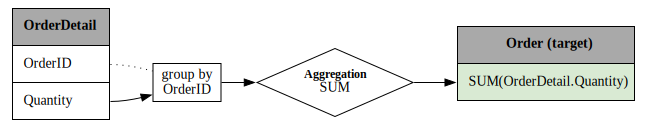

Feature name		: SUM(OrderDetail.Quantity)
Feature description	: The sum of the "Quantity" of all instances of "OrderDetail" for each "OrderID" in "Order".

2. OrderTotalUniqueItems


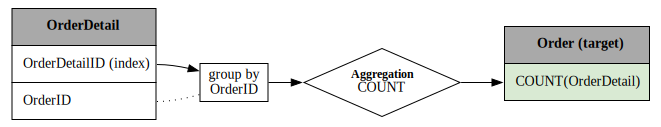

Feature name		: COUNT(OrderDetail)
Feature description	: The number of all instances of "OrderDetail" for each "OrderID" in "Order".

3. DaysToShip


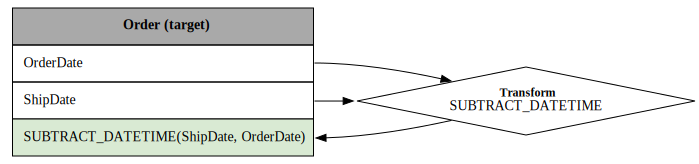

Feature name		: SUBTRACT_DATETIME(ShipDate, OrderDate)
Feature description	: The result of applying SUBTRACT_DATETIME to the "ShipDate", the "OrderDate".

4. OrderSubtotal


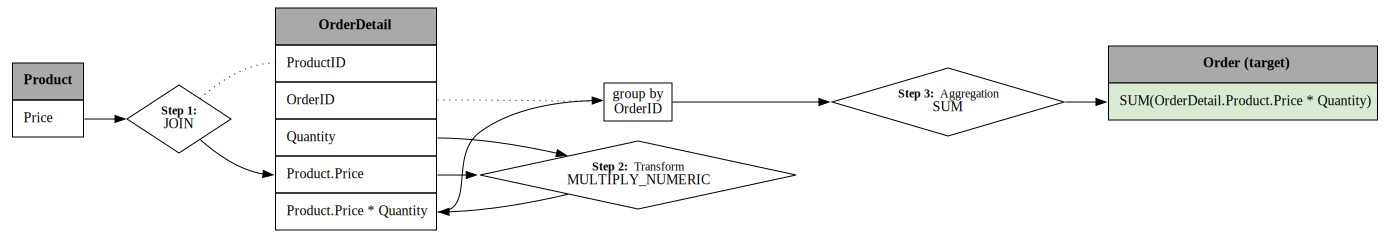

Feature name		: SUM(OrderDetail.Product.Price * Quantity)
Feature description	: The sum of the product of the "Price" for the instance of "Product" associated with this instance of "OrderDetail" and the "Quantity" of all instances of "OrderDetail" for each "OrderID" in "Order".

5. OrderDiscountAmount


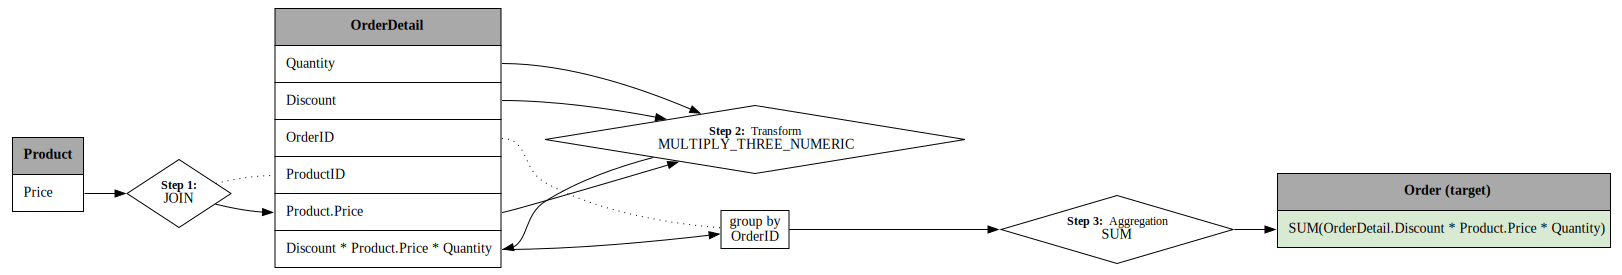

Feature name		: SUM(OrderDetail.Discount * Product.Price * Quantity)
Feature description	: The sum of the result of applying MULTIPLY_THREE_NUMERIC to the "Discount", the "Price" for the instance of "Product" associated with this instance of "OrderDetail", the "Quantity" of all instances of "OrderDetail" for each "OrderID" in "Order".



In [19]:
for i, var_name in enumerate(order_results):
    feat_obj = order_results[var_name]["feature_obj"]
    feat_name = order_results[var_name]["feature_name"]
    
    print(f"{i+1}. {var_name}")
    display_svg(ft.graph_feature(feat_obj))
    print(f"Feature name\t\t: {feat_name}")
    print(f"Feature description\t: {ft.describe_feature(feat_obj)}")
    print()

### Create deeper features by running DFS on generated features

Based on the initial generated features (e.g., `"OrderSubtotal"` and `"OrderDiscountAmount"`), it's desirable to have a deeper feature that tell the **grand total** of the order by subtracting `"OrderDiscountAmount"` from `"OrderSubtotal"`. Thus, let's try running DFS on the already-generated features for the second time.

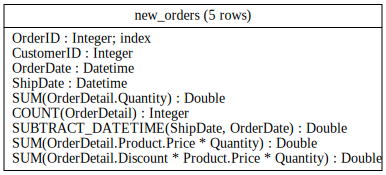

In [20]:
# Create a new df by joining the original orders with the newly generated features
new_orders_df = pd.merge(
    orders_df, 
    feature_matrix[[order_results[var_name]["feature_name"] for var_name in order_results]].reset_index(), 
    left_on="OrderID", right_on="OrderID"
)

# Define new entity set
deeper_order_es = ft.EntitySet("deeper_orders")
deeper_order_es.add_dataframe(dataframe=new_orders_df, dataframe_name="new_orders", index="OrderID")

display_svg(deeper_order_es.plot())

In [21]:
deeper_feature_matrix, deeper_feature_defs = ft.dfs(
    entityset=deeper_order_es,
    target_dataframe_name="new_orders", 
    trans_primitives=[ft.primitives.SubtractNumeric(commutative=False)]
)

#### Result

Perform DFS on the new `Order` table that consists of previously generated features yield the following useful features:

- `SUM(OrderDetail.Product.Price * Quantity) - SUM(OrderDetail.Discount * Product.Price * Quantity)`: the grand total amount to pay after discount

In [22]:
# Update order_results with the newly generated feature
order_results["OrderGrandTotal"] = {
    "feature_name": "SUM(OrderDetail.Product.Price * Quantity) - SUM(OrderDetail.Discount * Product.Price * Quantity)",
    "feature_obj": get_feature_by_name(feature_defs=deeper_feature_defs, feature_name="SUM(OrderDetail.Product.Price * Quantity) - SUM(OrderDetail.Discount * Product.Price * Quantity)")
}

deeper_feature_matrix[[order_results["OrderGrandTotal"]["feature_name"]]].T

OrderID,301,302,303,304,305
SUM(OrderDetail.Product.Price * Quantity) - SUM(OrderDetail.Discount * Product.Price * Quantity),1000.0,900.0,800.0,220.0,950.0


OrderGrandTotal


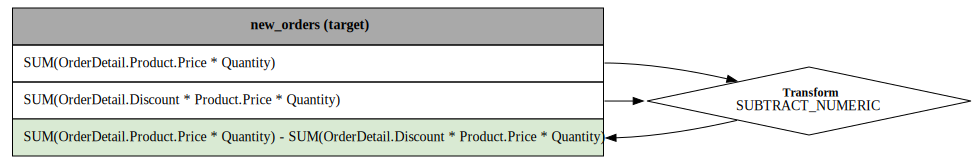

Feature name		: SUM(OrderDetail.Product.Price * Quantity) - SUM(OrderDetail.Discount * Product.Price * Quantity)
Feature description	: The result of the "SUM(OrderDetail.Product.Price * Quantity)" minus the "SUM(OrderDetail.Discount * Product.Price * Quantity)".


In [23]:
var_name = "OrderGrandTotal"
feat_name = order_results[var_name]["feature_name"]
feat_obj = order_results[var_name]["feature_obj"]

print(var_name)
display_svg(ft.graph_feature(feat_obj))
print(f"Feature name\t\t: {feat_name}")
print(f"Feature description\t: {ft.describe_feature(feat_obj)}")

## Exploring `OrderDetail` table

Drilling down on `OrderDetail` table to find out potential features.

In [24]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="OrderDetail",
    max_depth=3,
    agg_primitives=[],
    trans_primitives=["multiply_numeric", MultiplyThreeNumeric]
)

#### Result

Perform DFS on `OrderDetail` table yield the following features that might be useful for data warehouse:

- `Product.Price * Quantity`: the amount to pay before discount for each order detail
- `Discount * Product.Price * Quantity`: the discount amount for each order detail

In [25]:
# Collect the useful features generated
order_detail_results = {
    "OrderDetailSubtotal": {
        "feature_name": "Product.Price * Quantity",
        "feature_obj": get_feature_by_name(feature_defs=feature_defs, feature_name="Product.Price * Quantity"),
    },
    "OrderDetailDiscountAmount": {
        "feature_name": "Discount * Product.Price * Quantity",
        "feature_obj": get_feature_by_name(feature_defs=feature_defs, feature_name="Discount * Product.Price * Quantity"),
    },  
}

feature_matrix[[order_detail_results[var_name]["feature_name"] for var_name in order_detail_results]].T

OrderDetailID,301_201,302_202,303_203,304_204,304_205,305_205,305_204,305_201
Product.Price * Quantity,1000.0,1000.0,800.0,100.0,150.0,50.0,200.0,1000.0
Discount * Product.Price * Quantity,0.0,100.0,0.0,0.0,30.0,0.0,0.0,300.0


1. OrderDetailSubtotal


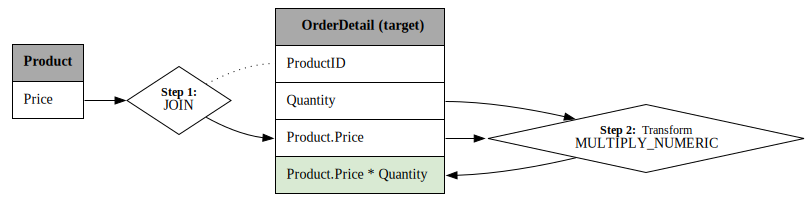

Feature name		: Product.Price * Quantity
Feature description	: The product of the "Price" for the instance of "Product" associated with this instance of "OrderDetail" and the "Quantity".

2. OrderDetailDiscountAmount


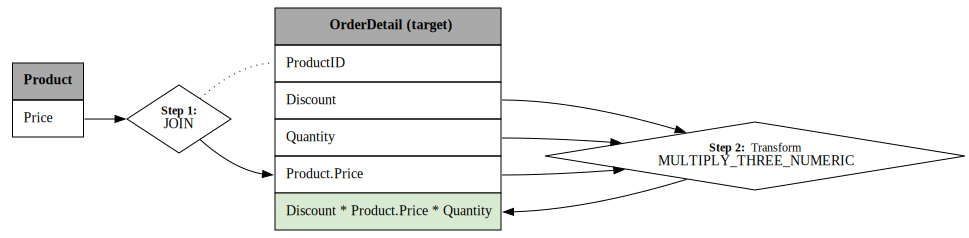

Feature name		: Discount * Product.Price * Quantity
Feature description	: The result of applying MULTIPLY_THREE_NUMERIC to the "Discount", the "Price" for the instance of "Product" associated with this instance of "OrderDetail", the "Quantity".



In [26]:
for i, var_name in enumerate(order_detail_results):
    feat_obj = order_detail_results[var_name]["feature_obj"]
    feat_name = order_detail_results[var_name]["feature_name"]
    
    print(f"{i+1}. {var_name}")
    display_svg(ft.graph_feature(feat_obj))
    print(f"Feature name\t\t: {feat_name}")
    print(f"Feature description\t: {ft.describe_feature(feat_obj)}")
    print()

### Create deeper features by running DFS on generated features

Based on the initial generated features for `OrderDetail` (e.g., `"OrderDetailSubtotal"` and `"OrderDetailDiscountAmount"`), it's desirable to have a deeper feature that tell the **total payable amount** of the order detail by subtracting `"OrderDetailDiscountAmount"` from `"OrderDetailSubtotal"`. Thus, let's try running DFS on the already-generated features for the second time.

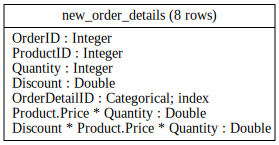

In [27]:
# Create a new df by joining the original orders with the newly generated features
new_order_details_df = pd.merge(
    order_details_df, 
    feature_matrix[[order_detail_results[var_name]["feature_name"] for var_name in order_detail_results]].reset_index(), 
    left_on="OrderDetailID", right_on="OrderDetailID"
)

deeper_order_detail_es = ft.EntitySet("deeper_order_details")
deeper_order_detail_es.add_dataframe(dataframe=new_order_details_df, dataframe_name="new_order_details", index="OrderDetailID")

display_svg(deeper_order_detail_es.plot())

In [28]:
deeper_feature_matrix, deeper_feature_defs = ft.dfs(
    entityset=deeper_order_detail_es,
    target_dataframe_name="new_order_details", 
    trans_primitives=[ft.primitives.SubtractNumeric(commutative=False)]
)

#### Result

Perform DFS on the new `OrderDetail` table that consists of previously generated features yield the following useful features:

- `Product.Price * Quantity - Discount * Product.Price * Quantity`: the total amount to pay after discount for each order detail

In [29]:
# Update order_detail_results with the newly generated feature
order_detail_results["OrderDetailPayableAmount"] = {
    "feature_name": "Product.Price * Quantity - Discount * Product.Price * Quantity",
    "feature_obj": get_feature_by_name(feature_defs=deeper_feature_defs, feature_name="Product.Price * Quantity - Discount * Product.Price * Quantity")
}

deeper_feature_matrix[[order_detail_results["OrderDetailPayableAmount"]["feature_name"]]].T

OrderDetailID,301_201,302_202,303_203,304_204,304_205,305_205,305_204,305_201
Product.Price * Quantity - Discount * Product.Price * Quantity,1000.0,900.0,800.0,100.0,120.0,50.0,200.0,700.0


OrderDetailPayableAmount


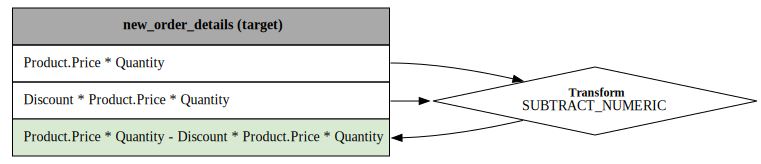

Feature name		: Product.Price * Quantity - Discount * Product.Price * Quantity
Feature description	: The result of the "Product.Price * Quantity" minus the "Discount * Product.Price * Quantity".


In [30]:
var_name = "OrderDetailPayableAmount"
feat_name = order_detail_results[var_name]["feature_name"]
feat_obj = order_detail_results[var_name]["feature_obj"]

print(var_name)
display_svg(ft.graph_feature(feat_obj))
print(f"Feature name\t\t: {feat_name}")
print(f"Feature description\t: {ft.describe_feature(feat_obj)}")

## Getting the derivatives of `date`

A simple date attribute can be decomposed into multiple sub-attributes (e.g., `"day"`, `"weekday"`, `"week"`, `"quarter"`, `"month"`, `"year"`).

In [31]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="Order",
    agg_primitives=[],
    trans_primitives=["day", "weekday", "week", "quarter", "month", "year"]
)

#### Result

Applying transformation on date (e.g., `OrderDate`) yields these:

- `DAY(OrderDate)`: Extracts the day of the month from the `OrderDate`.
- `WEEKDAY(OrderDate)`: Determines the day of the week (Monday is 0 and Sunday is 6) for the `OrderDate`.
- `WEEK(OrderDate)`: Identifies the week number of the year for the `OrderDate`.
- `QUARTER(OrderDate)`: Determines the quarter of the year for the `OrderDate`.
- `MONTH(OrderDate)`: Extracts the month from the `OrderDate`.
- `YEAR(OrderDate)`: Extracts the year from the `OrderDate`.

In [32]:
# Collect the useful features generated
date_attr_name = "OrderDate" # ShipDate

date_results = {
    "day": {
        "feature_name": f"DAY({date_attr_name})",
        "feature_obj": get_feature_by_name(feature_defs=feature_defs, feature_name=f"DAY({date_attr_name})"),
    },
    "weekday": {
        "feature_name": f"WEEKDAY({date_attr_name})",
        "feature_obj": get_feature_by_name(feature_defs=feature_defs, feature_name=f"WEEKDAY({date_attr_name})"),
    },
    "week": {
        "feature_name": f"WEEK({date_attr_name})",
        "feature_obj": get_feature_by_name(feature_defs=feature_defs, feature_name=f"WEEK({date_attr_name})"),
    },
    "month": {
        "feature_name": f"MONTH({date_attr_name})",
        "feature_obj": get_feature_by_name(feature_defs=feature_defs, feature_name=f"MONTH({date_attr_name})"),
    },
    "quarter": {
        "feature_name": f"QUARTER({date_attr_name})",
        "feature_obj": get_feature_by_name(feature_defs=feature_defs, feature_name=f"QUARTER({date_attr_name})"),
    },
    "year": {
        "feature_name": f"YEAR({date_attr_name})",
        "feature_obj": get_feature_by_name(feature_defs=feature_defs, feature_name=f"YEAR({date_attr_name})"),
    },
}

feature_matrix[[date_results[var_name]["feature_name"] for var_name in date_results]].T

OrderID,301,302,303,304,305
DAY(OrderDate),1,5,10,15,20
WEEKDAY(OrderDate),2,6,4,2,0
WEEK(OrderDate),5,5,6,7,8
MONTH(OrderDate),2,2,2,2,2
QUARTER(OrderDate),1,1,1,1,1
YEAR(OrderDate),2023,2023,2023,2023,2023


1. day


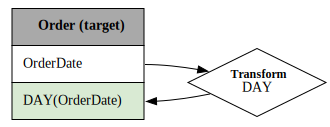

Feature name		: DAY(OrderDate)
Feature description	: The day of the month of the "OrderDate".

2. weekday


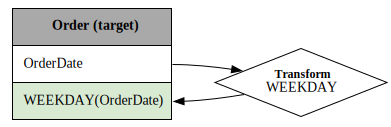

Feature name		: WEEKDAY(OrderDate)
Feature description	: The day of the week of the "OrderDate".

3. week


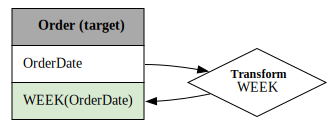

Feature name		: WEEK(OrderDate)
Feature description	: The week of the year of the "OrderDate".

4. month


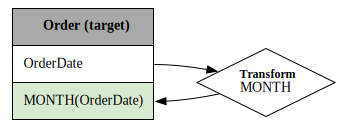

Feature name		: MONTH(OrderDate)
Feature description	: The month of the "OrderDate".

5. quarter


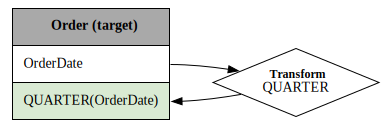

Feature name		: QUARTER(OrderDate)
Feature description	: The quarter that describes the "OrderDate".

6. year


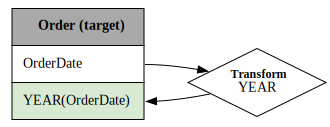

Feature name		: YEAR(OrderDate)
Feature description	: The year of the "OrderDate".



In [33]:
for i, var_name in enumerate(date_results):
    feat_obj = date_results[var_name]["feature_obj"]
    feat_name = date_results[var_name]["feature_name"]
    
    print(f"{i+1}. {var_name}")
    display_svg(ft.graph_feature(feat_obj))
    print(f"Feature name\t\t: {feat_name}")
    print(f"Feature description\t: {ft.describe_feature(feat_obj)}")
    print()